### Metrics calculation and some plots
Use this notebook to calculate the Dice scores for the images the network was not trained on. This works for the registration predictions. Just set the paths to the networks predictions correctly and the notebook will do the rest.

#### Set paths

In [5]:
nca_exps = '/media/aranem_locale/AR_subs_exps/BMVC_2024_NCA-Morph/MIDL_2024_trained_models/NCA_Morph'
rigid_exps = '/media/aranem_locale/AR_subs_exps/BMVC_2024_NCA-Morph/MIDL_2024_trained_models/Rigid'
syn_exps = '/media/aranem_locale/AR_subs_exps/BMVC_2024_NCA-Morph/MIDL_2024_trained_models/SyN'
syncc_exps = '/media/aranem_locale/AR_subs_exps/BMVC_2024_NCA-Morph/MIDL_2024_trained_models/SyNCC'
elasticsyn_exps = '/media/aranem_locale/AR_subs_exps/BMVC_2024_NCA-Morph/MIDL_2024_trained_models/ElasticSyN'
vxm_exps = '/media/aranem_locale/AR_subs_exps/BMVC_2024_NCA-Morph/MIDL_2024_trained_models/VoxelMorph'
nice_exps = '/media/aranem_locale/AR_subs_exps/BMVC_2024_NCA-Morph/MIDL_2024_trained_models/NICE_Trans'
vitvnet_exps = '/media/aranem_locale/AR_subs_exps/BMVC_2024_NCA-Morph/MIDL_2024_trained_models/ViTVNet'
transmorph_exps = '/media/aranem_locale/AR_subs_exps/BMVC_2024_NCA-Morph/MIDL_2024_trained_models/TransMorph'

#### Import necessary libraries

In [6]:
import numpy as np
import pandas as pd
import seaborn as sns
import SimpleITK as sitk
import matplotlib.pyplot as plt
from torch.autograd import Variable
import os, pystrum, copy, monai, torch

os.environ['NEURITE_BACKEND'] = "pytorch"
import neurite as ne
sns.set(context="paper", style="white", font_scale=3.5, rc={'axes.linewidth': 0.05})

#### Helpful functions and other stuffs

In [7]:
def adjust_lightness(color, amount=0.5):
    import matplotlib.colors as mc
    import colorsys
    try:
        c = mc.cnames[color]
    except:
        c = color
    c = colorsys.rgb_to_hls(*mc.to_rgb(c))
    return colorsys.hls_to_rgb(c[0], max(0, min(1, amount * c[1])), c[2])
    
def trunc(values, decs=0):
    return np.trunc(values*10**decs)/(10**decs)
    
hip_keys = ['Hippocampus_Dryad_0'+"%03d" % x for x in range(1, 31)]
hip_keys.extend(['Hippocampus_Harp_0'+"%03d" % x for x in range(1, 31)])

prost_keys = ['Prostate_HK_0'+ str(x) for x in range(121, 151)]
prost_keys.extend(['Prostate_I2CVB_0'+ str(x) for x in range(121, 151)])
    
val_keys = {'Task210_OASIS': ['OASIS_0'+str(x) for x in range(365, 415)],
            'Task211_Prostate': prost_keys,
            'Task212_Hippocampus': hip_keys}

In [28]:
models = [x for x in os.listdir(rigid_exps)]

models.sort()
dices_t = dict()
mse_nt = dict()
mse_nmt = dict()
dices_t_violin = dict()
for model in models:
    dices_t[model] = dict()
    mse_nt[model] = dict()
    mse_nmt[model] = dict()
    dices_t_violin[model] = list()
    preds_ = [x for x in os.listdir(os.path.join(rigid_exps, model)) if 'predictions' in x]
    print(os.listdir(os.path.join(rigid_exps, model)))
    for pred in preds_:
        preds = os.path.join(rigid_exps, model, pred)
        print(f"Looking in {preds}..")
        # -- Load the data -- #
        try:
            ds = [x for x in os.listdir(preds) if 'csv' not in x]
            ds.sort()
            print(f'Dice for model {model}:')
        except:
            continue
        for datas in ds:
            dices_ = list()
            mse_t = list()
            mse_n = list()
            dices_nmt = list()
            dices_t[model][datas] = dict()
            mse_nt[model][datas] = dict()
            mse_nmt[model][datas] = dict()
            cases = val_keys[datas]
            for case in cases:
                dices_t[model][datas][case] = dict()
                mse_nt[model][datas][case] = dict()
                mse_nmt[model][datas][case] = dict()
                gt = sitk.GetArrayFromImage(sitk.ReadImage(os.path.join(preds, datas, case, 'fixed_seg.nii.gz')))
                y_p = sitk.GetArrayFromImage(sitk.ReadImage(os.path.join(preds, datas, case, 'moved_seg.nii.gz')))
                # y_nm = sitk.GetArrayFromImage(sitk.ReadImage(os.path.join(preds, datas, case, 'moving_seg.nii.gz')))
                y_p_t = torch.from_numpy(y_p.astype(np.int32)).to(0).unsqueeze(0).unsqueeze(0).float()#.permute(0, 4, 1, 2, 3)
                # y_nm_t = torch.from_numpy(y_nm).to(0).unsqueeze(0).unsqueeze(0).float()#.permute(0, 4, 1, 2, 3)
                gt_t = torch.from_numpy(gt.astype(np.float32)).to(0).unsqueeze(0).unsqueeze(0).float()#.permute(0, 4, 1, 2, 3)
                dice = monai.metrics.DiceMetric(include_background=False, ignore_empty=False)(y_p_t, gt_t).cpu()
                dices_t[model][datas][case]['moved'] = np.round(dice, 4)
                dices_t_violin[model].append(np.round(dice, 4))
                dices_.append(dice)

                # dice = monai.metrics.DiceMetric(include_background=False, ignore_empty=False)(y_nm_t, gt_t).cpu()
                # dices_t[model][datas][case]['not_moved'] = np.round(dice, 4)
                # dices_t_violin[model].append(np.round(dice, 4))
                # dices_nmt.append(dice)
                
                MSE = np.square(np.subtract(gt, y_p)).mean()
                mse_nt[model][datas][case]['mse'] = MSE
                mse_t.append(MSE)
                
                # MSE_ = np.square(np.subtract(gt, y_nm)).mean()
                # mse_nmt[model][datas][case]['mse'] = MSE_
                # mse_n.append(MSE_)

            print(f"{datas}: Mean dice +/- std: {trunc(np.round(np.mean(dices_), decimals=4)*100, 2)} ({trunc(np.round(np.std(dices_), decimals=4)*100, 2)})") 
            # print(f"{datas} nm: Mean dice +/- std: {trunc(np.round(np.mean(dices_nmt), decimals=4)*100, 2)} ({trunc(np.round(np.std(dices_nmt), decimals=4)*100, 2)})")
            print(f"{datas} mean MSE +/- std: {trunc(np.round(np.mean(mse_t), decimals=4), 2)} ({trunc(np.round(np.std(mse_t), decimals=4), 2)})")
            # print(f"{datas} nm: mean MSE +/- std: {trunc(np.round(np.mean(mse_n), decimals=4), 2)} ({trunc(np.round(np.std(mse_n), decimals=4), 2)})")

            dices_t[model][datas]['mean_dice_moved'] = np.mean(dices_)
            dices_t[model][datas]['mean_std_moved'] = np.std(dices_)
            dices_t[model][datas]['mean_dice_std_moved'] = str(np.round(np.mean(dices_), 4)) + '(' + str(np.round(np.std(dices_), 4)) +')'
            # dices_t[model][datas]['mean_dice_not_moved'] = np.mean(dices_nmv)
            # dices_t[model][datas]['mean_std_not_moved'] = np.std(dices_nmv)
            # dices_t[model][datas]['mean_dice_std_not_moved'] = str(np.round(np.mean(dices_), 4)) + '+/-' + str(np.round(np.std(dices_nmv), 4))
        print()

['predictions']
Looking in /media/aranem_locale/AR_subs_exps/MIDL_2024_NCA-Morph/MIDL_2024_trained_models/Rigid/210/predictions..
Dice for model 210:
Task210_OASIS: Mean dice +/- std: 0.0 (0.0)
Task210_OASIS mean MSE +/- std: 26.41 (0.77)

['predictions']
Looking in /media/aranem_locale/AR_subs_exps/MIDL_2024_NCA-Morph/MIDL_2024_trained_models/Rigid/211/predictions..
Dice for model 211:
Task211_Prostate: Mean dice +/- std: 53.36 (16.15)
Task211_Prostate mean MSE +/- std: 0.01 (0.0)

['predictions']
Looking in /media/aranem_locale/AR_subs_exps/MIDL_2024_NCA-Morph/MIDL_2024_trained_models/Rigid/212/predictions..
Dice for model 212:
Task212_Hippocampus: Mean dice +/- std: 32.33 (24.04)
Task212_Hippocampus mean MSE +/- std: 0.02 (0.0)



In [33]:
models = [x for x in os.listdir(syn_exps)]

models.sort()
dices_t = dict()
mse_nt = dict()
mse_nmt = dict()
dices_t_violin = dict()
for model in models:
    dices_t[model] = dict()
    mse_nt[model] = dict()
    mse_nmt[model] = dict()
    dices_t_violin[model] = list()
    preds_ = [x for x in os.listdir(os.path.join(syn_exps, model)) if 'predictions' in x]
    print(os.listdir(os.path.join(syn_exps, model)))
    for pred in preds_:
        preds = os.path.join(syn_exps, model, pred)
        print(f"Looking in {preds}..")
        # -- Load the data -- #
        try:
            ds = [x for x in os.listdir(preds) if 'csv' not in x]
            ds.sort()
            print(f'Dice for model {model}:')
        except:
            continue
        for datas in ds:
            dices_ = list()
            mse_t = list()
            mse_n = list()
            dices_nmt = list()
            dices_t[model][datas] = dict()
            mse_nt[model][datas] = dict()
            mse_nmt[model][datas] = dict()
            cases = val_keys[datas]
            for case in cases:
                dices_t[model][datas][case] = dict()
                mse_nt[model][datas][case] = dict()
                mse_nmt[model][datas][case] = dict()
                gt = sitk.GetArrayFromImage(sitk.ReadImage(os.path.join(preds, datas, case, 'fixed_seg.nii.gz')))
                y_p = sitk.GetArrayFromImage(sitk.ReadImage(os.path.join(preds, datas, case, 'moved_seg.nii.gz')))
                # y_nm = sitk.GetArrayFromImage(sitk.ReadImage(os.path.join(preds, datas, case, 'moving_seg.nii.gz')))
                y_p_t = torch.from_numpy(y_p.astype(np.int32)).to(0).unsqueeze(0).unsqueeze(0).float()#.permute(0, 4, 1, 2, 3)
                # y_nm_t = torch.from_numpy(y_nm).to(0).unsqueeze(0).unsqueeze(0).float()#.permute(0, 4, 1, 2, 3)
                gt_t = torch.from_numpy(gt.astype(np.float32)).to(0).unsqueeze(0).unsqueeze(0).float()#.permute(0, 4, 1, 2, 3)
                dice = monai.metrics.DiceMetric(include_background=False, ignore_empty=False)(y_p_t, gt_t).cpu()
                # dice = monai.metrics.regression.SSIMMetric(3)(y_p_t, gt_t).cpu()
                dices_t[model][datas][case]['moved'] = np.round(dice, 4)
                dices_t_violin[model].append(np.round(dice, 4))
                dices_.append(dice)

                # dice = monai.metrics.DiceMetric(include_background=False, ignore_empty=False)(y_nm_t, gt_t).cpu()
                # dices_t[model][datas][case]['not_moved'] = np.round(dice, 4)
                # dices_t_violin[model].append(np.round(dice, 4))
                # dices_nmt.append(dice)
                
                MSE = np.square(np.subtract(gt, y_p)).mean()
                mse_nt[model][datas][case]['mse'] = MSE
                mse_t.append(MSE)
                
                # MSE_ = np.square(np.subtract(gt, y_nm)).mean()
                # mse_nmt[model][datas][case]['mse'] = MSE_
                # mse_n.append(MSE_)

            print(f"{datas}: Mean dice +/- std: {trunc(np.round(np.mean(dices_), decimals=4)*100, 2)} ({trunc(np.round(np.std(dices_), decimals=4)*100, 2)})") 
            # print(f"{datas} nm: Mean dice +/- std: {trunc(np.round(np.mean(dices_nmt), decimals=4)*100, 2)} ({trunc(np.round(np.std(dices_nmt), decimals=4)*100, 2)})")
            print(f"{datas} mean MSE +/- std: {trunc(np.round(np.mean(mse_t), decimals=4), 2)} ({trunc(np.round(np.std(mse_t), decimals=4), 2)})")
            # print(f"{datas} nm: mean MSE +/- std: {trunc(np.round(np.mean(mse_n), decimals=4), 2)} ({trunc(np.round(np.std(mse_n), decimals=4), 2)})")

            dices_t[model][datas]['mean_dice_moved'] = np.mean(dices_)
            dices_t[model][datas]['mean_std_moved'] = np.std(dices_)
            dices_t[model][datas]['mean_dice_std_moved'] = str(np.round(np.mean(dices_), 4)) + '(' + str(np.round(np.std(dices_), 4)) +')'
            # dices_t[model][datas]['mean_dice_not_moved'] = np.mean(dices_nmv)
            # dices_t[model][datas]['mean_std_not_moved'] = np.std(dices_nmv)
            # dices_t[model][datas]['mean_dice_std_not_moved'] = str(np.round(np.mean(dices_), 4)) + '+/-' + str(np.round(np.std(dices_nmv), 4))
        print()

['predictions']
Looking in /media/aranem_locale/AR_subs_exps/MIDL_2024_NCA-Morph/MIDL_2024_trained_models/SyN/210/predictions..
Dice for model 210:
Task210_OASIS: Mean dice +/- std: 68.58 (1.56)
Task210_OASIS mean MSE +/- std: 7.49 (0.88)

['predictions']
Looking in /media/aranem_locale/AR_subs_exps/MIDL_2024_NCA-Morph/MIDL_2024_trained_models/SyN/211/predictions..
Dice for model 211:
Task211_Prostate: Mean dice +/- std: 49.32 (21.02)
Task211_Prostate mean MSE +/- std: 0.01 (0.0)

['predictions']
Looking in /media/aranem_locale/AR_subs_exps/MIDL_2024_NCA-Morph/MIDL_2024_trained_models/SyN/212/predictions..
Dice for model 212:
Task212_Hippocampus: Mean dice +/- std: 35.26 (24.61)
Task212_Hippocampus mean MSE +/- std: 0.01 (0.01)



In [35]:
models = [x for x in os.listdir(syncc_exps)]

models.sort()
dices_t = dict()
mse_nt = dict()
mse_nmt = dict()
dices_t_violin = dict()
for model in models:
    dices_t[model] = dict()
    mse_nt[model] = dict()
    mse_nmt[model] = dict()
    dices_t_violin[model] = list()
    preds_ = [x for x in os.listdir(os.path.join(syncc_exps, model)) if 'predictions' in x]
    print(os.listdir(os.path.join(syncc_exps, model)))
    for pred in preds_:
        preds = os.path.join(syncc_exps, model, pred)
        print(f"Looking in {preds}..")
        # -- Load the data -- #
        try:
            ds = [x for x in os.listdir(preds) if 'csv' not in x]
            ds.sort()
            print(f'Dice for model {model}:')
        except:
            continue
        for datas in ds:
            dices_ = list()
            mse_t = list()
            mse_n = list()
            dices_nmt = list()
            dices_t[model][datas] = dict()
            mse_nt[model][datas] = dict()
            mse_nmt[model][datas] = dict()
            cases = val_keys[datas]
            for case in cases:
                dices_t[model][datas][case] = dict()
                mse_nt[model][datas][case] = dict()
                mse_nmt[model][datas][case] = dict()
                gt = sitk.GetArrayFromImage(sitk.ReadImage(os.path.join(preds, datas, case, 'fixed_seg.nii.gz')))
                y_p = sitk.GetArrayFromImage(sitk.ReadImage(os.path.join(preds, datas, case, 'moved_seg.nii.gz')))
                # y_nm = sitk.GetArrayFromImage(sitk.ReadImage(os.path.join(preds, datas, case, 'moving_seg.nii.gz')))
                y_p_t = torch.from_numpy(y_p.astype(np.int32)).to(0).unsqueeze(0).unsqueeze(0).float()#.permute(0, 4, 1, 2, 3)
                # y_nm_t = torch.from_numpy(y_nm).to(0).unsqueeze(0).unsqueeze(0).float()#.permute(0, 4, 1, 2, 3)
                gt_t = torch.from_numpy(gt.astype(np.float32)).to(0).unsqueeze(0).unsqueeze(0).float()#.permute(0, 4, 1, 2, 3)
                dice = monai.metrics.DiceMetric(include_background=False, ignore_empty=False)(y_p_t, gt_t).cpu()
                # dice = monai.metrics.regression.SSIMMetric(3)(y_p_t, gt_t).cpu()
                dices_t[model][datas][case]['moved'] = np.round(dice, 4)
                dices_t_violin[model].append(np.round(dice, 4))
                dices_.append(dice)

                # dice = monai.metrics.DiceMetric(include_background=False, ignore_empty=False)(y_nm_t, gt_t).cpu()
                # dices_t[model][datas][case]['not_moved'] = np.round(dice, 4)
                # dices_t_violin[model].append(np.round(dice, 4))
                # dices_nmt.append(dice)
                
                MSE = np.square(np.subtract(gt, y_p)).mean()
                mse_nt[model][datas][case]['mse'] = MSE
                mse_t.append(MSE)
                
                # MSE_ = np.square(np.subtract(gt, y_nm)).mean()
                # mse_nmt[model][datas][case]['mse'] = MSE_
                # mse_n.append(MSE_)

            print(f"{datas}: Mean dice +/- std: {trunc(np.round(np.mean(dices_), decimals=4)*100, 2)} ({trunc(np.round(np.std(dices_), decimals=4)*100, 2)})") 
            # print(f"{datas} nm: Mean dice +/- std: {trunc(np.round(np.mean(dices_nmt), decimals=4)*100, 2)} ({trunc(np.round(np.std(dices_nmt), decimals=4)*100, 2)})")
            print(f"{datas} mean MSE +/- std: {trunc(np.round(np.mean(mse_t), decimals=4), 2)} ({trunc(np.round(np.std(mse_t), decimals=4), 2)})")
            # print(f"{datas} nm: mean MSE +/- std: {trunc(np.round(np.mean(mse_n), decimals=4), 2)} ({trunc(np.round(np.std(mse_n), decimals=4), 2)})")

            dices_t[model][datas]['mean_dice_moved'] = np.mean(dices_)
            dices_t[model][datas]['mean_std_moved'] = np.std(dices_)
            dices_t[model][datas]['mean_dice_std_moved'] = str(np.round(np.mean(dices_), 4)) + '(' + str(np.round(np.std(dices_), 4)) +')'
            # dices_t[model][datas]['mean_dice_not_moved'] = np.mean(dices_nmv)
            # dices_t[model][datas]['mean_std_not_moved'] = np.std(dices_nmv)
            # dices_t[model][datas]['mean_dice_std_not_moved'] = str(np.round(np.mean(dices_), 4)) + '+/-' + str(np.round(np.std(dices_nmv), 4))
        print()

['predictions']
Looking in /media/aranem_locale/AR_subs_exps/MIDL_2024_NCA-Morph/MIDL_2024_trained_models/SyNCC/210/predictions..
Dice for model 210:
Task210_OASIS: Mean dice +/- std: 72.0 (1.53)
Task210_OASIS mean MSE +/- std: 5.38 (0.67)

['predictions']
Looking in /media/aranem_locale/AR_subs_exps/MIDL_2024_NCA-Morph/MIDL_2024_trained_models/SyNCC/211/predictions..
Dice for model 211:
Task211_Prostate: Mean dice +/- std: 51.88 (22.13)
Task211_Prostate mean MSE +/- std: 0.01 (0.0)

['predictions']
Looking in /media/aranem_locale/AR_subs_exps/MIDL_2024_NCA-Morph/MIDL_2024_trained_models/SyNCC/212/predictions..
Dice for model 212:
Task212_Hippocampus: Mean dice +/- std: 32.03 (27.12)
Task212_Hippocampus mean MSE +/- std: 0.01 (0.01)



In [29]:
models = [x for x in os.listdir(elasticsyn_exps)]

models.sort()
dices_t = dict()
mse_nt = dict()
mse_nmt = dict()
dices_t_violin = dict()
for model in models:
    dices_t[model] = dict()
    mse_nt[model] = dict()
    mse_nmt[model] = dict()
    dices_t_violin[model] = list()
    preds_ = [x for x in os.listdir(os.path.join(elasticsyn_exps, model)) if 'predictions' in x]
    print(os.listdir(os.path.join(elasticsyn_exps, model)))
    for pred in preds_:
        preds = os.path.join(elasticsyn_exps, model, pred)
        print(f"Looking in {preds}..")
        # -- Load the data -- #
        try:
            ds = [x for x in os.listdir(preds) if 'csv' not in x]
            ds.sort()
            print(f'Dice for model {model}:')
        except:
            continue
        for datas in ds:
            dices_ = list()
            mse_t = list()
            mse_n = list()
            dices_nmt = list()
            dices_t[model][datas] = dict()
            mse_nt[model][datas] = dict()
            mse_nmt[model][datas] = dict()
            cases = val_keys[datas]
            for case in cases:
                dices_t[model][datas][case] = dict()
                mse_nt[model][datas][case] = dict()
                mse_nmt[model][datas][case] = dict()
                gt = sitk.GetArrayFromImage(sitk.ReadImage(os.path.join(preds, datas, case, 'fixed_seg.nii.gz')))
                y_p = sitk.GetArrayFromImage(sitk.ReadImage(os.path.join(preds, datas, case, 'moved_seg.nii.gz')))
                # y_nm = sitk.GetArrayFromImage(sitk.ReadImage(os.path.join(preds, datas, case, 'moving_seg.nii.gz')))
                y_p_t = torch.from_numpy(y_p.astype(np.int32)).to(0).unsqueeze(0).unsqueeze(0).float()#.permute(0, 4, 1, 2, 3)
                # y_nm_t = torch.from_numpy(y_nm).to(0).unsqueeze(0).unsqueeze(0).float()#.permute(0, 4, 1, 2, 3)
                gt_t = torch.from_numpy(gt.astype(np.float32)).to(0).unsqueeze(0).unsqueeze(0).float()#.permute(0, 4, 1, 2, 3)
                dice = monai.metrics.DiceMetric(include_background=False, ignore_empty=False)(y_p_t, gt_t).cpu()
                dices_t[model][datas][case]['moved'] = np.round(dice, 4)
                dices_t_violin[model].append(np.round(dice, 4))
                dices_.append(dice)

                # dice = monai.metrics.DiceMetric(include_background=False, ignore_empty=False)(y_nm_t, gt_t).cpu()
                # dices_t[model][datas][case]['not_moved'] = np.round(dice, 4)
                # dices_t_violin[model].append(np.round(dice, 4))
                # dices_nmt.append(dice)
                
                MSE = np.square(np.subtract(gt, y_p)).mean()
                mse_nt[model][datas][case]['mse'] = MSE
                mse_t.append(MSE)
                
                # MSE_ = np.square(np.subtract(gt, y_nm)).mean()
                # mse_nmt[model][datas][case]['mse'] = MSE_
                # mse_n.append(MSE_)

            print(f"{datas}: Mean dice +/- std: {trunc(np.round(np.mean(dices_), decimals=4)*100, 2)} ({trunc(np.round(np.std(dices_), decimals=4)*100, 2)})") 
            # print(f"{datas} nm: Mean dice +/- std: {trunc(np.round(np.mean(dices_nmt), decimals=4)*100, 2)} ({trunc(np.round(np.std(dices_nmt), decimals=4)*100, 2)})")
            print(f"{datas} mean MSE +/- std: {trunc(np.round(np.mean(mse_t), decimals=4), 2)} ({trunc(np.round(np.std(mse_t), decimals=4), 2)})")
            # print(f"{datas} nm: mean MSE +/- std: {trunc(np.round(np.mean(mse_n), decimals=4), 2)} ({trunc(np.round(np.std(mse_n), decimals=4), 2)})")

            dices_t[model][datas]['mean_dice_moved'] = np.mean(dices_)
            dices_t[model][datas]['mean_std_moved'] = np.std(dices_)
            dices_t[model][datas]['mean_dice_std_moved'] = str(np.round(np.mean(dices_), 4)) + '(' + str(np.round(np.std(dices_), 4)) +')'
            # dices_t[model][datas]['mean_dice_not_moved'] = np.mean(dices_nmv)
            # dices_t[model][datas]['mean_std_not_moved'] = np.std(dices_nmv)
            # dices_t[model][datas]['mean_dice_std_not_moved'] = str(np.round(np.mean(dices_), 4)) + '+/-' + str(np.round(np.std(dices_nmv), 4))
        print()

['predictions']
Looking in /media/aranem_locale/AR_subs_exps/MIDL_2024_NCA-Morph/MIDL_2024_trained_models/ElasticSyN/210/predictions..
Dice for model 210:
Task210_OASIS: Mean dice +/- std: 68.59 (1.59)
Task210_OASIS mean MSE +/- std: 7.49 (0.87)

['predictions']
Looking in /media/aranem_locale/AR_subs_exps/MIDL_2024_NCA-Morph/MIDL_2024_trained_models/ElasticSyN/211/predictions..
Dice for model 211:
Task211_Prostate: Mean dice +/- std: 50.66 (21.25)
Task211_Prostate mean MSE +/- std: 0.01 (0.0)

['predictions']
Looking in /media/aranem_locale/AR_subs_exps/MIDL_2024_NCA-Morph/MIDL_2024_trained_models/ElasticSyN/212/predictions..
Dice for model 212:
Task212_Hippocampus: Mean dice +/- std: 30.0 (27.0)
Task212_Hippocampus mean MSE +/- std: 0.02 (0.01)



### TransMorph results

In [17]:
models = [x for x in os.listdir(transmorph_exps) if 'transmorph' in x]

models.sort()
dices_t = dict()
jcp_nt = dict()
mse_nt = dict()
mse_nmt = dict()
dices_t_violin = dict()
for model in models:
    dices_t[model] = dict()
    jcp_nt[model] = dict()
    mse_nt[model] = dict()
    mse_nmt[model] = dict()
    dices_t_violin[model] = list()
    preds_ = [x for x in os.listdir(os.path.join(transmorph_exps, model)) if 'predictions' in x]
    for pred in preds_:
        preds = os.path.join(transmorph_exps, model, pred)
        print(f"Looking in {preds}..")
        # -- Load the data -- #
        try:
            ds = [x for x in os.listdir(preds) if 'csv' not in x]
            ds.sort()
            print(f'Dice for model {model}:')
        except:
            continue
        for datas in ds:
            dices_ = list()
            jcb_t = list()
            mse_t = list()
            mse_n = list()
            dices_nmt = list()
            dices_t[model][datas] = dict()
            jcp_nt[model][datas] = dict()
            mse_nt[model][datas] = dict()
            mse_nmt[model][datas] = dict()
            cases = val_keys[datas]
            for case in cases:
                dices_t[model][datas][case] = dict()
                jcp_nt[model][datas][case] = dict()
                mse_nt[model][datas][case] = dict()
                mse_nmt[model][datas][case] = dict()
                gt = sitk.GetArrayFromImage(sitk.ReadImage(os.path.join(preds, datas, case, 'fixed_seg.nii.gz')))
                y_p = sitk.GetArrayFromImage(sitk.ReadImage(os.path.join(preds, datas, case, 'moved_seg.nii.gz')))
                y_nm = sitk.GetArrayFromImage(sitk.ReadImage(os.path.join(preds, datas, case, 'moving_seg.nii.gz')))
                y_p_t = torch.from_numpy(y_p).to(0).unsqueeze(0).unsqueeze(0).float()#.permute(0, 4, 1, 2, 3)
                y_nm_t = torch.from_numpy(y_nm).to(0).unsqueeze(0).unsqueeze(0).float()#.permute(0, 4, 1, 2, 3)
                gt_t = torch.from_numpy(gt).to(0).unsqueeze(0).unsqueeze(0).float()#.permute(0, 4, 1, 2, 3)
                dice = monai.metrics.DiceMetric(include_background=False, ignore_empty=False)(y_p_t, gt_t).cpu()
                dices_t[model][datas][case]['moved'] = np.round(dice, 4)
                dices_t_violin[model].append(np.round(dice, 4))
                dices_.append(dice)
            
                transform = sitk.ReadImage(os.path.join(preds, datas, case, 'flow.nii.gz'), sitk.sitkVectorFloat64)   ## the deformation field was saved as 'transform.txt'
                outTx = sitk.DisplacementFieldTransform(transform)
                v = sitk.DisplacementFieldJacobianDeterminant(outTx.GetDisplacementField())
                jcb = sitk.GetArrayFromImage(v)    ##jcb is the Jacobian determinant array
                jcb_neg = np.count_nonzero(jcb <= 0)
                jcb_pos = np.count_nonzero(jcb > 0)
                jcb_all= jcb_neg + jcb_pos
                jcp_nt[model][datas][case]['jcb_neg'] = jcb_neg
                jcp_nt[model][datas][case]['jcb_pos'] = jcb_pos
                jcp_nt[model][datas][case]['jcb_all'] = jcb_all
                jcp_nt[model][datas][case]['jcb_neg_perc'] = jcb_neg/jcb_all
                # perc = jcb_neg/jcb_all
                jcb_t.append(jcb_neg)
                
                dice = monai.metrics.DiceMetric(include_background=False, ignore_empty=False)(y_nm_t, gt_t).cpu()
                dices_t[model][datas][case]['not_moved'] = np.round(dice, 4)
                # dices_t_violin[model].append(np.round(dice, 4))
                dices_nmt.append(dice)
                
                MSE = np.square(np.subtract(gt, y_p)).mean()
                mse_nt[model][datas][case]['mse'] = MSE
                mse_t.append(MSE)
                
                MSE_ = np.square(np.subtract(gt, y_nm)).mean()
                mse_nmt[model][datas][case]['mse'] = MSE_
                mse_n.append(MSE_)

            print(f"{datas}: Mean dice +/- std: {trunc(np.round(np.mean(dices_), decimals=4)*100, 2)} ({trunc(np.round(np.std(dices_), decimals=4)*100, 2)})") 
            print(f"{datas} nm: Mean dice +/- std: {trunc(np.round(np.mean(dices_nmt), decimals=4)*100, 2)} ({trunc(np.round(np.std(dices_nmt), decimals=4)*100, 2)})")
            print(f"{datas} jcb <= 0: Mean jcb +/- std: {trunc(np.round(np.mean(jcb_t), decimals=4), 2)} ({trunc(np.round(np.std(jcb_t), decimals=4), 2)})")
            print(f"{datas} mean MSE +/- std: {trunc(np.round(np.mean(mse_t), decimals=4), 2)} ({trunc(np.round(np.std(mse_t), decimals=4), 2)})")
            print(f"{datas} nm: mean MSE +/- std: {trunc(np.round(np.mean(mse_n), decimals=4), 2)} ({trunc(np.round(np.std(mse_n), decimals=4), 2)})")

            dices_t[model][datas]['mean_dice_moved'] = np.mean(dices_)
            dices_t[model][datas]['mean_std_moved'] = np.std(dices_)
            dices_t[model][datas]['mean_dice_std_moved'] = str(np.round(np.mean(dices_), 4)) + '(' + str(np.round(np.std(dices_), 4)) +')'
            # dices_t[model][datas]['mean_dice_not_moved'] = np.mean(dices_nmv)
            # dices_t[model][datas]['mean_std_not_moved'] = np.std(dices_nmv)
            # dices_t[model][datas]['mean_dice_std_not_moved'] = str(np.round(np.mean(dices_), 4)) + '+/-' + str(np.round(np.std(dices_nmv), 4))
        print()

Looking in /home/aranem_locale/Desktop/mnts/local/scratch/aranem/CVPR_2024/CVPR_2024_trained_models/TransMorph/transmorph_torch_250_210_ncc_ce_default/predictions..
Dice for model transmorph_torch_250_210_ncc_ce_default:
Task210_OASIS: Mean dice +/- std: 93.8 (0.82)
Task210_OASIS nm: Mean dice +/- std: 63.1 (2.61)
Task210_OASIS jcb <= 0: Mean jcb +/- std: 283837.26 (20883.2)
Task210_OASIS mean MSE +/- std: 3.65 (0.45)
Task210_OASIS nm: mean MSE +/- std: 15.08 (1.28)

Looking in /home/aranem_locale/Desktop/mnts/local/scratch/aranem/CVPR_2024/CVPR_2024_trained_models/TransMorph/transmorph_torch_250_210_ncc_ce_tiny/predictions..
Dice for model transmorph_torch_250_210_ncc_ce_tiny:
Task210_OASIS: Mean dice +/- std: 90.49 (1.29)
Task210_OASIS nm: Mean dice +/- std: 63.1 (2.61)
Task210_OASIS jcb <= 0: Mean jcb +/- std: 377999.64 (32540.99)
Task210_OASIS mean MSE +/- std: 5.7 (0.69)
Task210_OASIS nm: mean MSE +/- std: 15.08 (1.28)

Looking in /home/aranem_locale/Desktop/mnts/local/scratch/ara

### ViT-V-Net results

In [25]:
models = [x for x in os.listdir(vitvnet_exps) if 'vitvnet' in x]

models.sort()
dices_vit = dict()
jcp_nvit = dict()
mse_nvit = dict()
mse_nmv = dict()
dices_vit_violin = dict()
for model in models:
    dices_vit[model] = dict()
    jcp_nvit[model] = dict()
    mse_nvit[model] = dict()
    mse_nmv[model] = dict()
    dices_vit_violin[model] = list()
    preds_ = [x for x in os.listdir(os.path.join(vitvnet_exps, model)) if 'predictions' in x]
    for pred in preds_:
        preds = os.path.join(vitvnet_exps, model, pred)
        print(f"Looking in {preds}..")
        # -- Load the data -- #
        try:
            ds = [x for x in os.listdir(preds) if 'csv' not in x]
            ds.sort()
            print(f'Dice for model {model}:')
        except:
            continue
        for datas in ds:
            dices_ = list()
            jcb_v = list()
            mse_v = list()
            mse_n = list()
            dices_nmv = list()
            dices_vit[model][datas] = dict()
            jcp_nvit[model][datas] = dict()
            mse_nvit[model][datas] = dict()
            mse_nmv[model][datas] = dict()
            cases = val_keys[datas]
            for case in cases:
                dices_vit[model][datas][case] = dict()
                jcp_nvit[model][datas][case] = dict()
                mse_nvit[model][datas][case] = dict()
                mse_nmv[model][datas][case] = dict()
                gt = sitk.GetArrayFromImage(sitk.ReadImage(os.path.join(preds, datas, case, 'fixed_seg.nii.gz')))
                y_p = sitk.GetArrayFromImage(sitk.ReadImage(os.path.join(preds, datas, case, 'moved_seg.nii.gz')))
                y_nm = sitk.GetArrayFromImage(sitk.ReadImage(os.path.join(preds, datas, case, 'moving_seg.nii.gz')))
                y_p_t = torch.from_numpy(y_p).to(0).unsqueeze(0).unsqueeze(0).float()#.permute(0, 4, 1, 2, 3)
                y_nm_t = torch.from_numpy(y_nm).to(0).unsqueeze(0).unsqueeze(0).float()#.permute(0, 4, 1, 2, 3)
                gt_t = torch.from_numpy(gt).to(0).unsqueeze(0).unsqueeze(0).float()#.permute(0, 4, 1, 2, 3)
                dice = monai.metrics.DiceMetric(include_background=False, ignore_empty=False)(y_p_t, gt_t).cpu()
                dices_vit[model][datas][case]['moved'] = np.round(dice, 4)
                dices_vit_violin[model].append(np.round(dice, 4))
                dices_.append(dice)
                
                transform = sitk.ReadImage(os.path.join(preds, datas, case, 'flow.nii.gz'), sitk.sitkVectorFloat64)   ## the deformation field was saved as 'transform.txt'
                outTx = sitk.DisplacementFieldTransform(transform)
                v = sitk.DisplacementFieldJacobianDeterminant(outTx.GetDisplacementField())
                jcb = sitk.GetArrayFromImage(v)    ##jcb is the Jacobian determinant array
                jcb_neg = np.count_nonzero(jcb <= 0)
                jcb_pos = np.count_nonzero(jcb > 0)
                jcb_all= jcb_neg + jcb_pos
                jcp_nvit[model][datas][case]['jcb_neg'] = jcb_neg
                jcp_nvit[model][datas][case]['jcb_pos'] = jcb_pos
                jcp_nvit[model][datas][case]['jcb_all'] = jcb_all
                jcp_nvit[model][datas][case]['jcb_neg_perc'] = jcb_neg/jcb_all
                # perc = jcb_neg/jcb_all
                jcb_v.append(jcb_neg)
                
                dice = monai.metrics.DiceMetric(include_background=False, ignore_empty=False)(y_nm_t, gt_t).cpu()
                dices_vit[model][datas][case]['not_moved'] = np.round(dice, 4)
                # dices_vit_violin[model].append(np.round(dice, 4))
                dices_nmv.append(dice)
                
                MSE = np.square(np.subtract(gt, y_p)).mean()
                mse_nvit[model][datas][case]['mse'] = MSE
                mse_v.append(MSE)
                
                MSE_ = np.square(np.subtract(gt, y_nm)).mean()
                mse_nmv[model][datas][case]['mse'] = MSE_
                mse_n.append(MSE_)
    
            print(f"{datas}: Mean dice +/- std: {trunc(np.round(np.mean(dices_), decimals=4)*100, 2)} ({trunc(np.round(np.std(dices_), decimals=4)*100, 2)})") 
            print(f"{datas} nm: Mean dice +/- std: {trunc(np.round(np.mean(dices_nmv), decimals=4)*100, 2)} ({trunc(np.round(np.std(dices_nmv), decimals=4)*100, 2)})")
            print(f"{datas} jcb <= 0: Mean jcb +/- std: {trunc(np.round(np.mean(jcb_v), decimals=4), 2)} ({trunc(np.round(np.std(jcb_v), decimals=4), 2)})")
            print(f"{datas} mean MSE +/- std: {trunc(np.round(np.mean(mse_v), decimals=4), 2)} ({trunc(np.round(np.std(mse_v), decimals=4), 2)})")
            print(f"{datas} nm: mean MSE +/- std: {trunc(np.round(np.mean(mse_n), decimals=4), 2)} ({trunc(np.round(np.std(mse_n), decimals=4), 2)})")
    
            dices_vit[model][datas]['mean_dice_moved'] = np.mean(dices_)
            dices_vit[model][datas]['mean_std_moved'] = np.std(dices_)
            dices_vit[model][datas]['mean_dice_std_moved'] = str(np.round(np.mean(dices_), 4)) + '(' + str(np.round(np.std(dices_), 4)) +')'
            # dices_vit[model][datas]['mean_dice_not_moved'] = np.mean(dices_nmv)
            # dices_vit[model][datas]['mean_std_not_moved'] = np.std(dices_nmv)
            # dices_vit[model][datas]['mean_dice_std_not_moved'] = str(np.round(np.mean(dices_), 4)) + '+/-' + str(np.round(np.std(dices_nmv), 4))
        print()

Looking in /home/aranem_locale/Desktop/mnts/local/scratch/aranem/CVPR_2024/CVPR_2024_trained_models/ViTVNet/vitvnet_torch_250_210_ncc_ce/predictions..
Dice for model vitvnet_torch_250_210_ncc_ce:
Task210_OASIS: Mean dice +/- std: 93.25 (0.88)
Task210_OASIS nm: Mean dice +/- std: 63.1 (2.61)
Task210_OASIS jcb <= 0: Mean jcb +/- std: 310838.68 (25593.31)
Task210_OASIS mean MSE +/- std: 4.31 (0.56)
Task210_OASIS nm: mean MSE +/- std: 15.08 (1.28)

Looking in /home/aranem_locale/Desktop/mnts/local/scratch/aranem/CVPR_2024/CVPR_2024_trained_models/ViTVNet/vitvnet_torch_250_211_ncc_ce/predictions..
Dice for model vitvnet_torch_250_211_ncc_ce:
Task211_Prostate: Mean dice +/- std: 27.61 (19.76)
Task211_Prostate nm: Mean dice +/- std: 53.36 (16.15)
Task211_Prostate jcb <= 0: Mean jcb +/- std: 111511.03 (72308.26)
Task211_Prostate mean MSE +/- std: 0.01 (0.0)
Task211_Prostate nm: mean MSE +/- std: 0.01 (0.0)

Looking in /home/aranem_locale/Desktop/mnts/local/scratch/aranem/CVPR_2024/CVPR_2024_tr

### NICE-Trans results

In [26]:
models = [x for x in os.listdir(nice_exps) if 'nice' in x]

models.sort()
dices_nice = dict()
jcp_nice = dict()
mse_nice = dict()
mse_nmnice = dict()
dices_nice_violin = dict()
for model in models:
    dices_nice[model] = dict()
    jcp_nice[model] = dict()
    mse_nice[model] = dict()
    mse_nmnice[model] = dict()
    dices_nice_violin[model] = list()
    preds_ = [x for x in os.listdir(os.path.join(nice_exps, model)) if 'predictions' in x]
    for pred in preds_:
        preds = os.path.join(nice_exps, model, pred)
        print(f"Looking in {preds}..")
        # -- Load the data -- #
        try:
            ds = [x for x in os.listdir(preds) if 'csv' not in x]
            ds.sort()
            print(f'Dice for model {model}:')
        except:
            continue
        for datas in ds:
            dices_ = list()
            jcb_v = list()
            mse_v = list()
            mse_n = list()
            dices_nmv = list()
            dices_nice[model][datas] = dict()
            jcp_nice[model][datas] = dict()
            mse_nice[model][datas] = dict()
            mse_nmnice[model][datas] = dict()
            cases = val_keys[datas]
            for case in cases:
                dices_nice[model][datas][case] = dict()
                jcp_nice[model][datas][case] = dict()
                mse_nice[model][datas][case] = dict()
                mse_nmnice[model][datas][case] = dict()
                gt = sitk.GetArrayFromImage(sitk.ReadImage(os.path.join(preds, datas, case, 'fixed_seg.nii.gz')))
                y_p = sitk.GetArrayFromImage(sitk.ReadImage(os.path.join(preds, datas, case, 'moved_seg.nii.gz')))
                y_nm = sitk.GetArrayFromImage(sitk.ReadImage(os.path.join(preds, datas, case, 'moving_seg.nii.gz')))
                y_p_t = torch.from_numpy(y_p).to(0).unsqueeze(0).unsqueeze(0).float()#.permute(0, 4, 1, 2, 3)
                y_nm_t = torch.from_numpy(y_nm).to(0).unsqueeze(0).unsqueeze(0).float()#.permute(0, 4, 1, 2, 3)
                gt_t = torch.from_numpy(gt).to(0).unsqueeze(0).unsqueeze(0).float()#.permute(0, 4, 1, 2, 3)
                dice = monai.metrics.DiceMetric(include_background=False, ignore_empty=False)(y_p_t, gt_t).cpu()
                dices_nice[model][datas][case]['moved'] = np.round(dice, 4)
                dices_nice_violin[model].append(np.round(dice, 4))
                dices_.append(dice)
                
                transform = sitk.ReadImage(os.path.join(preds, datas, case, 'flow.nii.gz'), sitk.sitkVectorFloat64)   ## the deformation field was saved as 'transform.txt'
                outTx = sitk.DisplacementFieldTransform(transform)
                v = sitk.DisplacementFieldJacobianDeterminant(outTx.GetDisplacementField())
                jcb = sitk.GetArrayFromImage(v)    ##jcb is the Jacobian determinant array
                jcb_neg = np.count_nonzero(jcb <= 0)
                jcb_pos = np.count_nonzero(jcb > 0)
                jcb_all= jcb_neg + jcb_pos
                jcp_nice[model][datas][case]['jcb_neg'] = jcb_neg
                jcp_nice[model][datas][case]['jcb_pos'] = jcb_pos
                jcp_nice[model][datas][case]['jcb_all'] = jcb_all
                jcp_nice[model][datas][case]['jcb_neg_perc'] = jcb_neg/jcb_all
                # perc = jcb_neg/jcb_all
                jcb_v.append(jcb_neg)
                
                dice = monai.metrics.DiceMetric(include_background=False, ignore_empty=False)(y_nm_t, gt_t).cpu()
                dices_nice[model][datas][case]['not_moved'] = np.round(dice, 4)
                # dices_niceviolin[model].append(np.round(dice, 4))
                dices_nmv.append(dice)
                
                MSE = np.square(np.subtract(gt, y_p)).mean()
                mse_nice[model][datas][case]['mse'] = MSE
                mse_v.append(MSE)
                
                MSE_ = np.square(np.subtract(gt, y_nm)).mean()
                mse_nmnice[model][datas][case]['mse'] = MSE_
                mse_n.append(MSE_)
    
            print(f"{datas}: Mean dice +/- std: {trunc(np.round(np.mean(dices_), decimals=4)*100, 2)} ({trunc(np.round(np.std(dices_), decimals=4)*100, 2)})") 
            print(f"{datas} nm: Mean dice +/- std: {trunc(np.round(np.mean(dices_nmv), decimals=4)*100, 2)} ({trunc(np.round(np.std(dices_nmv), decimals=4)*100, 2)})")
            print(f"{datas} jcb <= 0: Mean jcb +/- std: {trunc(np.round(np.mean(jcb_v), decimals=4), 2)} ({trunc(np.round(np.std(jcb_v), decimals=4), 2)})")
            print(f"{datas} mean MSE +/- std: {trunc(np.round(np.mean(mse_v), decimals=4), 2)} ({trunc(np.round(np.std(mse_v), decimals=4), 2)})")
            print(f"{datas} nm: mean MSE +/- std: {trunc(np.round(np.mean(mse_n), decimals=4), 2)} ({trunc(np.round(np.std(mse_n), decimals=4), 2)})")
    
            dices_nice[model][datas]['mean_dice_moved'] = np.mean(dices_)
            dices_nice[model][datas]['mean_std_moved'] = np.std(dices_)
            dices_nice[model][datas]['mean_dice_std_moved'] = str(np.round(np.mean(dices_), 4)) + '(' + str(np.round(np.std(dices_), 4)) +')'
            # dices_nice[model][datas]['mean_dice_not_moved'] = np.mean(dices_nmv)
            # dices_nice[model][datas]['mean_std_not_moved'] = np.std(dices_nmv)
            # dices_nice[model][datas]['mean_dice_std_not_moved'] = str(np.round(np.mean(dices_), 4)) + '+/-' + str(np.round(np.std(dices_nmv), 4))
        print()

Looking in /home/aranem_locale/Desktop/mnts/local/scratch/aranem/CVPR_2024/CVPR_2024_trained_models/NICE_Trans/nicetrans_torch_250_210_ncc_ce/predictions..
Dice for model nicetrans_torch_250_210_ncc_ce:
Task210_OASIS: Mean dice +/- std: 94.95 (0.62)
Task210_OASIS nm: Mean dice +/- std: 63.1 (2.61)
Task210_OASIS jcb <= 0: Mean jcb +/- std: 305219.98 (29009.66)
Task210_OASIS mean MSE +/- std: 2.96 (0.45)
Task210_OASIS nm: mean MSE +/- std: 15.08 (1.28)

Looking in /home/aranem_locale/Desktop/mnts/local/scratch/aranem/CVPR_2024/CVPR_2024_trained_models/NICE_Trans/nicetrans_torch_250_211_ncc_ce_not_working/predictions..
Dice for model nicetrans_torch_250_211_ncc_ce_not_working:
Task211_Prostate: Mean dice +/- std: 0.0 (0.0)
Task211_Prostate nm: Mean dice +/- std: 53.36 (16.15)
Task211_Prostate jcb <= 0: Mean jcb +/- std: 2342902.51 (19687.1)
Task211_Prostate mean MSE +/- std: 0.01 (0.0)
Task211_Prostate nm: mean MSE +/- std: 0.01 (0.0)

Looking in /home/aranem_locale/Desktop/mnts/local/scr

### VoxelMorph results

In [22]:
models = [x for x in os.listdir(vxm_exps) if 'vxm' in x]

models.sort()
dices_v = dict()
jcp_nv = dict()
mse_nv = dict()
mse_nmv = dict()
dices_v_violin = dict()
for model in models:
    dices_v[model] = dict()
    jcp_nv[model] = dict()
    mse_nv[model] = dict()
    mse_nmv[model] = dict()
    dices_v_violin[model] = list()
    preds_ = [x for x in os.listdir(os.path.join(vxm_exps, model)) if 'predictions' in x]
    for pred in preds_:
        preds = os.path.join(vxm_exps, model, pred)
        print(f"Looking in {preds}..")
        # -- Load the data -- #
        try:
            ds = [x for x in os.listdir(preds) if 'csv' not in x]
            ds.sort()
            print(f'Dice for model {model}:')
        except:
            continue
        for datas in ds:
            dices_ = list()
            jcb_v = list()
            mse_v = list()
            mse_n = list()
            dices_nmv = list()
            dices_v[model][datas] = dict()
            jcp_nv[model][datas] = dict()
            mse_nv[model][datas] = dict()
            mse_nmv[model][datas] = dict()
            cases = val_keys[datas]
            for case in cases:
                dices_v[model][datas][case] = dict()
                jcp_nv[model][datas][case] = dict()
                mse_nv[model][datas][case] = dict()
                mse_nmv[model][datas][case] = dict()
                gt = sitk.GetArrayFromImage(sitk.ReadImage(os.path.join(preds, datas, case, 'fixed_seg.nii.gz')))
                y_p = sitk.GetArrayFromImage(sitk.ReadImage(os.path.join(preds, datas, case, 'moved_seg.nii.gz')))
                y_nm = sitk.GetArrayFromImage(sitk.ReadImage(os.path.join(preds, datas, case, 'moving_seg.nii.gz')))
                y_p_t = torch.from_numpy(y_p).to(0).unsqueeze(0).unsqueeze(0).float()#.permute(0, 4, 1, 2, 3)
                y_nm_t = torch.from_numpy(y_nm).to(0).unsqueeze(0).unsqueeze(0).float()#.permute(0, 4, 1, 2, 3)
                gt_t = torch.from_numpy(gt).to(0).unsqueeze(0).unsqueeze(0).float()#.permute(0, 4, 1, 2, 3)
                dice = monai.metrics.DiceMetric(include_background=False, ignore_empty=False)(y_p_t, gt_t).cpu()
                dices_v[model][datas][case]['moved'] = np.round(dice, 4)
                dices_v_violin[model].append(np.round(dice, 4))
                dices_.append(dice)
                
                transform = sitk.ReadImage(os.path.join(preds, datas, case, 'flow.nii.gz'), sitk.sitkVectorFloat64)   ## the deformation field was saved as 'transform.txt'
                outTx = sitk.DisplacementFieldTransform(transform)
                v = sitk.DisplacementFieldJacobianDeterminant(outTx.GetDisplacementField())
                jcb = sitk.GetArrayFromImage(v)    ##jcb is the Jacobian determinant array
                jcb_neg = np.count_nonzero(jcb <= 0)
                jcb_pos = np.count_nonzero(jcb > 0)
                jcb_all= jcb_neg + jcb_pos
                jcp_nv[model][datas][case]['jcb_neg'] = jcb_neg
                jcp_nv[model][datas][case]['jcb_pos'] = jcb_pos
                jcp_nv[model][datas][case]['jcb_all'] = jcb_all
                jcp_nv[model][datas][case]['jcb_neg_perc'] = jcb_neg/jcb_all
                # perc = jcb_neg/jcb_all
                jcb_v.append(jcb_neg)
                
                dice = monai.metrics.DiceMetric(include_background=False, ignore_empty=False)(y_nm_t, gt_t).cpu()
                dices_v[model][datas][case]['not_moved'] = np.round(dice, 4)
                # dices_v_violin[model].append(np.round(dice, 4))
                dices_nmv.append(dice)
                
                MSE = np.square(np.subtract(gt, y_p)).mean()
                mse_nv[model][datas][case]['mse'] = MSE
                mse_v.append(MSE)
                
                MSE_ = np.square(np.subtract(gt, y_nm)).mean()
                mse_nmv[model][datas][case]['mse'] = MSE_
                mse_n.append(MSE_)
    
            print(f"{datas}: Mean dice +/- std: {trunc(np.round(np.mean(dices_), decimals=4)*100, 2)} ({trunc(np.round(np.std(dices_), decimals=4)*100, 2)})") 
            print(f"{datas} nm: Mean dice +/- std: {trunc(np.round(np.mean(dices_nmv), decimals=4)*100, 2)} ({trunc(np.round(np.std(dices_nmv), decimals=4)*100, 2)})")
            print(f"{datas} jcb <= 0: Mean jcb +/- std: {trunc(np.round(np.mean(jcb_v), decimals=4), 2)} ({trunc(np.round(np.std(jcb_v), decimals=4), 2)})")
            print(f"{datas} mean MSE +/- std: {trunc(np.round(np.mean(mse_v), decimals=4), 2)} ({trunc(np.round(np.std(mse_v), decimals=4), 2)})")
            print(f"{datas} nm: mean MSE +/- std: {trunc(np.round(np.mean(mse_n), decimals=4), 2)} ({trunc(np.round(np.std(mse_n), decimals=4), 2)})")
    
            dices_v[model][datas]['mean_dice_moved'] = np.mean(dices_)
            dices_v[model][datas]['mean_std_moved'] = np.std(dices_)
            dices_v[model][datas]['mean_dice_std_moved'] = str(np.round(np.mean(dices_), 4)) + '(' + str(np.round(np.std(dices_), 4)) +')'
            # dices_v[model][datas]['mean_dice_not_moved'] = np.mean(dices_nmv)
            # dices_v[model][datas]['mean_std_not_moved'] = np.std(dices_nmv)
            # dices_v[model][datas]['mean_dice_std_not_moved'] = str(np.round(np.mean(dices_), 4)) + '+/-' + str(np.round(np.std(dices_nmv), 4))
        print()

Looking in /home/aranem_locale/Desktop/mnts/local/scratch/aranem/CVPR_2024/CVPR_2024_trained_models/VoxelMorph/vxm_torch_250_210_ncc_ce/predictions..
Dice for model vxm_torch_250_210_ncc_ce:
Task210_OASIS: Mean dice +/- std: 90.99 (1.02)
Task210_OASIS nm: Mean dice +/- std: 63.1 (2.61)
Task210_OASIS jcb <= 0: Mean jcb +/- std: 219371.32 (18106.45)
Task210_OASIS mean MSE +/- std: 5.08 (0.59)
Task210_OASIS nm: mean MSE +/- std: 15.08 (1.28)

Looking in /home/aranem_locale/Desktop/mnts/local/scratch/aranem/CVPR_2024/CVPR_2024_trained_models/VoxelMorph/vxm_torch_250_211_ncc_ce_not_working/predictions..
Dice for model vxm_torch_250_211_ncc_ce_not_working:
Task211_Prostate: Mean dice +/- std: 0.0 (0.0)
Task211_Prostate nm: Mean dice +/- std: 53.36 (16.15)
Task211_Prostate jcb <= 0: Mean jcb +/- std: 35950.4 (4139.19)
Task211_Prostate mean MSE +/- std: 0.01 (0.0)
Task211_Prostate nm: mean MSE +/- std: 0.01 (0.0)

Looking in /home/aranem_locale/Desktop/mnts/local/scratch/aranem/CVPR_2024/CVPR_

### NCA-Morph results

In [28]:
models = [x for x in os.listdir(nca_exps) if 'nca_morph' in x]

models.sort()
dices_n = dict()
jcp_nn = dict()
mse_nn = dict()
mse_nmn = dict()
dices_n_violin = dict()
for model in models:
    dices_n[model] = dict()
    jcp_nn[model] = dict()
    mse_nn[model] = dict()
    mse_nmn[model] = dict()
    dices_n_violin[model] = list()
    preds_ = [x for x in os.listdir(os.path.join(nca_exps, model)) if 'predictions' in x]
    for pred in preds_:
        preds = os.path.join(nca_exps, model, pred)
        print(f"Looking in {preds}..")
        # -- Load the data -- #
        try:
            ds = [x for x in os.listdir(preds) if 'csv' not in x]
            ds.sort()
            print(f'Dice for model {model}:')
        except:
            continue
        for datas in ds:
            dices_ = list()
            jcb_v = list()
            mse_v = list()
            mse_n = list()
            dices_nmv = list()
            dices_n[model][datas] = dict()
            jcp_nn[model][datas] = dict()
            mse_nn[model][datas] = dict()
            mse_nmn[model][datas] = dict()
            cases = val_keys[datas]
            for case in cases:
                dices_n[model][datas][case] = dict()
                jcp_nn[model][datas][case] = dict()
                mse_nn[model][datas][case] = dict()
                mse_nmn[model][datas][case] = dict()
                gt = sitk.GetArrayFromImage(sitk.ReadImage(os.path.join(preds, datas, case, 'fixed_seg.nii.gz')))
                y_p = sitk.GetArrayFromImage(sitk.ReadImage(os.path.join(preds, datas, case, 'moved_seg.nii.gz')))
                y_nm = sitk.GetArrayFromImage(sitk.ReadImage(os.path.join(preds, datas, case, 'moving_seg.nii.gz')))
                y_p_t = torch.from_numpy(y_p).to(0).unsqueeze(0).unsqueeze(0).float()#.permute(0, 4, 1, 2, 3)
                y_nm_t = torch.from_numpy(y_nm).to(0).unsqueeze(0).unsqueeze(0).float()#.permute(0, 4, 1, 2, 3)
                gt_t = torch.from_numpy(gt).to(0).unsqueeze(0).unsqueeze(0).float()#.permute(0, 4, 1, 2, 3)
                dice = monai.metrics.DiceMetric(include_background=False, ignore_empty=False)(y_p_t, gt_t).cpu()
                dices_n[model][datas][case]['moved'] = np.round(dice, 4)
                dices_n_violin[model].append(np.round(dice, 4))
                dices_.append(dice)
                
                transform = sitk.ReadImage(os.path.join(preds, datas, case, 'flow.nii.gz'), sitk.sitkVectorFloat64)   ## the deformation field was saved as 'transform.txt'
                outTx = sitk.DisplacementFieldTransform(transform)
                v = sitk.DisplacementFieldJacobianDeterminant(outTx.GetDisplacementField())
                jcb = sitk.GetArrayFromImage(v)    ##jcb is the Jacobian determinant array
                jcb_neg = np.count_nonzero(jcb <= 0)
                jcb_pos = np.count_nonzero(jcb > 0)
                jcb_all= jcb_neg + jcb_pos
                jcp_nn[model][datas][case]['jcb_neg'] = jcb_neg
                jcp_nn[model][datas][case]['jcb_pos'] = jcb_pos
                jcp_nn[model][datas][case]['jcb_all'] = jcb_all
                jcp_nn[model][datas][case]['jcb_neg_perc'] = jcb_neg/jcb_all
                # perc = jcb_neg/jcb_all
                jcb_v.append(jcb_neg)
                
                dice = monai.metrics.DiceMetric(include_background=False, ignore_empty=False)(y_nm_t, gt_t).cpu()
                dices_n[model][datas][case]['not_moved'] = np.round(dice, 4)
                # dices_n_violin[model].append(np.round(dice, 4))
                dices_nmv.append(dice)
                
                MSE = np.square(np.subtract(gt, y_p)).mean()
                mse_nn[model][datas][case]['mse'] = MSE
                mse_v.append(MSE)
                
                MSE_ = np.square(np.subtract(gt, y_nm)).mean()
                mse_nmn[model][datas][case]['mse'] = MSE_
                mse_n.append(MSE_)
    
            print(f"{datas}: Mean dice +/- std: {trunc(np.round(np.mean(dices_), decimals=4)*100, 2)} ({trunc(np.round(np.std(dices_), decimals=4)*100, 2)})") 
            print(f"{datas} nm: Mean dice +/- std: {trunc(np.round(np.mean(dices_nmv), decimals=4)*100, 2)} ({trunc(np.round(np.std(dices_nmv), decimals=4)*100, 2)})")
            print(f"{datas} jcb <= 0: Mean jcb +/- std: {trunc(np.round(np.mean(jcb_v), decimals=4), 2)} ({trunc(np.round(np.std(jcb_v), decimals=4), 2)})")
            print(f"{datas} mean MSE +/- std: {trunc(np.round(np.mean(mse_v), decimals=4), 2)} ({trunc(np.round(np.std(mse_v), decimals=4), 2)})")
            print(f"{datas} nm: mean MSE +/- std: {trunc(np.round(np.mean(mse_n), decimals=4), 2)} ({trunc(np.round(np.std(mse_n), decimals=4), 2)})")
    
            dices_n[model][datas]['mean_dice_moved'] = np.mean(dices_)
            dices_n[model][datas]['mean_std_moved'] = np.std(dices_)
            dices_n[model][datas]['mean_dice_std_moved'] = str(np.round(np.mean(dices_), 4)) + '(' + str(np.round(np.std(dices_), 4)) +')'
            # dices_n[model][datas]['mean_dice_not_moved'] = np.mean(dices_nmv)
            # dices_n[model][datas]['mean_std_not_moved'] = np.std(dices_nmv)
            # dices_n[model][datas]['mean_dice_std_not_moved'] = str(np.round(np.mean(dices_), 4)) + '+/-' + str(np.round(np.std(dices_nmv), 4))
        print()

Looking in /home/aranem_locale/Desktop/mnts/local/scratch/aranem/CVPR_2024/CVPR_2024_trained_models/NCA_Morph/nca_morph_torch_250_210_ncc_kernel_3_10_16_64/predictions..
Dice for model nca_morph_torch_250_210_ncc_kernel_3_10_16_64:
Task210_OASIS: Mean dice +/- std: 88.99 (1.44)
Task210_OASIS nm: Mean dice +/- std: 63.1 (2.61)
Task210_OASIS jcb <= 0: Mean jcb +/- std: 456803.66 (22490.8)
Task210_OASIS mean MSE +/- std: 6.66 (0.72)
Task210_OASIS nm: mean MSE +/- std: 15.08 (1.28)

Looking in /home/aranem_locale/Desktop/mnts/local/scratch/aranem/CVPR_2024/CVPR_2024_trained_models/NCA_Morph/nca_morph_torch_250_210_ncc_kernel_3_5_16_64/predictions..
Dice for model nca_morph_torch_250_210_ncc_kernel_3_5_16_64:
Task210_OASIS: Mean dice +/- std: 89.13 (1.27)
Task210_OASIS nm: Mean dice +/- std: 63.1 (2.61)
Task210_OASIS jcb <= 0: Mean jcb +/- std: 360048.6 (27372.16)
Task210_OASIS mean MSE +/- std: 6.66 (0.76)
Task210_OASIS nm: mean MSE +/- std: 15.08 (1.28)

Looking in /home/aranem_locale/Des

In [7]:
# Kernel size
data_kernel = pd.DataFrame([], columns=['Kernel Size', 'Dice'], dtype=float)
meandata_kernel = pd.DataFrame([], columns=['Kernel Size', 'Dice', 'STD'], dtype=float)
for i, (k, v) in enumerate(dices_n_violin.items()):
    if len(k) > 39 or k[-2:] != '30':
        continue
    
    for v_ in v:
        row = {'Kernel Size': k.split('_')[-2] + " $\times " + k.split('_')[-2], 'Dice': 100*float(v_[0])}
        new_df = pd.DataFrame([row])
        data_kernel = pd.concat([data_kernel, new_df], axis=0, ignore_index=True)
    row_mean = {'Kernel Size':  k.split('_')[-2] + " $\times " + k.split('_')[-2], 'Dice': 100*np.mean(v), 'STD': 100*np.std(v)}#, 'Method': 'NCA-Morph'}
    new_df_mean = pd.DataFrame([row_mean])
    meandata_kernel = pd.concat([meandata_kernel, new_df_mean], axis=0, ignore_index=True)


# Nr of steps
data_steps = pd.DataFrame([], columns=['Step Size', 'Dice'], dtype=float)
meandata_steps = pd.DataFrame([], columns=['Step Size', 'Dice', 'STD'], dtype=float)
for i, (k, v) in enumerate(dices_n_violin.items()):
    if len(k) > 39 or k[-6:-3] != '7_7':
        continue
    
    for v_ in v:
        row = {'Step Size': k[-2:], 'Dice': 100*float(v_[0])}
        new_df = pd.DataFrame([row])
        data_steps = pd.concat([data_steps, new_df], axis=0, ignore_index=True)
    row_mean = {'Step Size':  k[-2:], 'Dice': 100*np.mean(v), 'STD': 100*np.std(v)}#, 'Method': 'NCA-Morph'}
    new_df_mean = pd.DataFrame([row_mean])
    meandata_steps = pd.concat([meandata_steps, new_df_mean], axis=0, ignore_index=True)

    
# Robustness
data_robustness = pd.DataFrame([], columns=['Method', 'Dice', 'Artifact'], dtype=float)
meandata_robustness = pd.DataFrame([], columns=['Method', 'Dice', 'STD', 'Artifact'], dtype=float)
v_orig = 0.801802
for i, (k, v) in enumerate(dices_n_violin.items()):
    if 'ncc_kernel_7_7_10' in k and 'fire' not in k and 'flow' not in k:
        # print(k)
        v_list = list()
        artifact = "bias" if "bias" in k else "spike"  if "spike" in k else "ghosting" if "ghosting" in k else "none"
        level = 'Level 1' if 'level_1' in k else 'Level 2' if 'level_2' in k else 'Level 3' if 'level_3' in k else "none"
        for v_ in v:
            row = {'Method': "NCA-Morph$_{7 x 7}^{10}$", 'Dice': 100*(float(v_[0])-v_orig), 'Artifact': artifact, 'Level': level}
            v_list.append(float(v_[0])-v_orig)
            new_df = pd.DataFrame([row])
            data_robustness = pd.concat([data_robustness, new_df], axis=0, ignore_index=True)
        row_mean = {'Method':  "NCA-Morph$_{7 x 7}^{10}$", 'Dice': 100*np.mean(v_list), 'STD': 100*np.std(v_list), 'Artifact': artifact, 'Level': level}
        new_df_mean = pd.DataFrame([row_mean])
        meandata_robustness = pd.concat([meandata_robustness, new_df_mean], axis=0, ignore_index=True)
        
v_orig = 0.8459
for i, (k, v) in enumerate(dices_v_violin.items()):
    # print(k, v)
    v_list = list()
    artifact = "bias" if "bias" in k else "spike"  if "spike" in k else "ghosting" if "ghosting" in k else "none"
    level = 'Level 1' if 'level_1' in k else 'Level 2' if 'level_2' in k else 'Level 3' if 'level_3' in k else "none"
    for v_ in v:
        row = {'Method': "VoxelMorph", 'Dice': 100*(float(v_[0])-v_orig), 'Artifact': artifact, 'Level': level}
        new_df = pd.DataFrame([row])
        data_robustness = pd.concat([data_robustness, new_df], axis=0, ignore_index=True)
        v_list.append(float(v_[0])-v_orig)
    row_mean = {'Method':  "VoxelMorph", 'Dice': 100*np.mean(v_list), 'STD': 100*np.std(v_list), 'Artifact': artifact, 'Level': level}
    new_df_mean = pd.DataFrame([row_mean])
    meandata_robustness = pd.concat([meandata_robustness, new_df_mean], axis=0, ignore_index=True)

### Robustness

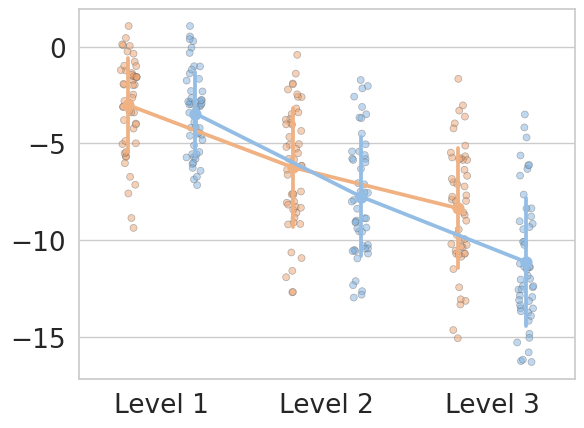

In [8]:
# plt.figure(figsize=(7, 3))
data_robustness_bias = data_robustness[(data_robustness['Artifact'] == 'bias')]
meandata_robustness_bias = meandata_robustness[(meandata_robustness['Artifact'] == 'bias')]
# Plot
sns.set_theme(style="whitegrid")
tips = sns.load_dataset("tips")
ax = sns.pointplot(data=data_robustness_bias, x="Level", y="Dice", errorbar="sd", hue='Method', palette=[adjust_lightness('#fae5d6', 0.8), adjust_lightness('#deebf7', 0.8)], dodge=0.41)
plt.setp(ax.lines, zorder=100)
plt.setp(ax.collections, zorder=100, label="")
sns.stripplot(x="Level", y="Dice", data=data_robustness_bias, hue='Method', palette=[adjust_lightness('#fae5d6', 0.75), adjust_lightness('#deebf7', 0.75)], dodge=0.15, alpha=0.5, linewidth=0.5, legend=False)#, jitter=False)
plt.xlabel("")
plt.ylabel("")
plt.legend([], [], frameon=False)
# plt.legend(loc='lower center', title='')
# plt.setp(ax.get_legend().get_texts(), fontsize='15') # for legend text
# sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
# ax.set_xlabel("",fontsize=30)
# ax.set_ylabel("",fontsize=20)
ax.tick_params(labelsize=5)
ax.tick_params(axis='both', labelsize=19)
plt.savefig('/media/aranem_locale/AR_subs_exps/CVPR_2024/CVPR_2024_evaluation/plots_cvpr/scatter_bias.pdf', bbox_inches='tight')

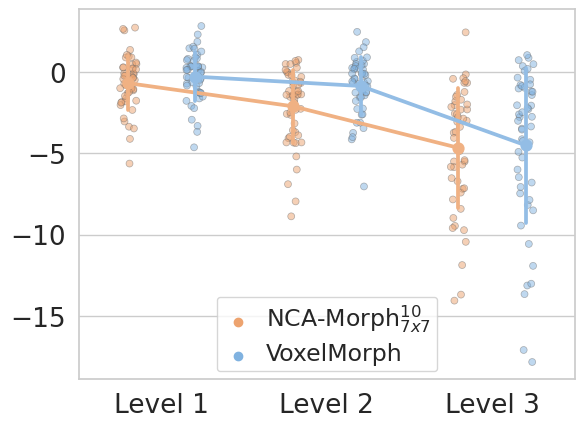

In [9]:
data_robustness_spike = data_robustness[(data_robustness['Artifact'] == 'spike')]
meandata_robustness_spike = meandata_robustness[(meandata_robustness['Artifact'] == 'spike')]
# Plot
sns.set_theme(style="whitegrid")
tips = sns.load_dataset("tips")
ax = sns.pointplot(data=data_robustness_spike, x="Level", y="Dice", errorbar="sd", hue='Method', palette=[adjust_lightness('#fae5d6', 0.8), adjust_lightness('#deebf7', 0.8)], dodge=0.41)
plt.setp(ax.lines, zorder=100)
plt.setp(ax.collections, zorder=100, label="")
sns.stripplot(x="Level", y="Dice", data=data_robustness_spike, hue='Method', palette=[adjust_lightness('#fae5d6', 0.75), adjust_lightness('#deebf7', 0.75)], dodge=0.15, alpha=0.5, linewidth=0.5)#, jitter=False)
plt.xlabel("")
plt.ylabel("")
plt.legend(loc='lower center', title='')
# ax.set_xlabel("Intensity",fontsize=23)
plt.setp(ax.get_legend().get_texts(), fontsize='17') # for legend text
ax.tick_params(axis='both', labelsize=19)
# sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
plt.savefig('/media/aranem_locale/AR_subs_exps/CVPR_2024/CVPR_2024_evaluation/plots_cvpr/scatter_spike.pdf', bbox_inches='tight')

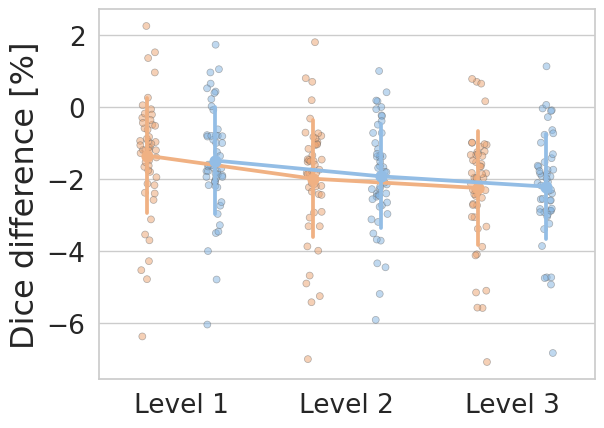

In [10]:
data_robustness_ghosting = data_robustness[(data_robustness['Artifact'] == 'ghosting')]
meandata_robustness_ghosting = meandata_robustness[(meandata_robustness['Artifact'] == 'ghosting')]
# Plot
sns.set_theme(style="whitegrid")
tips = sns.load_dataset("tips")
ax = sns.pointplot(data=data_robustness_ghosting, x="Level", y="Dice", errorbar="sd", hue='Method', palette=[adjust_lightness('#fae5d6', 0.8), adjust_lightness('#deebf7', 0.8)], dodge=0.41)
plt.setp(ax.lines, zorder=100)
plt.setp(ax.collections, zorder=100, label="")
sns.stripplot(x="Level", y="Dice", data=data_robustness_ghosting, hue='Method', palette=[adjust_lightness('#fae5d6', 0.75), adjust_lightness('#deebf7', 0.75)], dodge=0.15, alpha=0.5, linewidth=0.5, legend=False)#, jitter=False)
plt.xlabel("")
plt.ylabel("")
plt.legend([], [], frameon=False)
ax.set_ylabel("Dice difference [%]",fontsize=23)
# plt.legend(loc='lower center', title='')
# plt.setp(ax.get_legend().get_texts(), fontsize='8') # for legend text
# sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
ax.tick_params(axis='both', labelsize=19)
plt.savefig('/media/aranem_locale/AR_subs_exps/CVPR_2024/CVPR_2024_evaluation/plots_cvpr/scatter_ghosting.pdf', bbox_inches='tight')

### Computational Resource Analysis

In [31]:
methods = ["NCA-Morph$_{3 x 3}^{30}$", "NCA-Morph$_{5 x 5}^{30}$", "NCA-Morph$_{9 x 9}^{30}$", "NCA-Morph$_{7 x 7}^{10}$",
            "NCA-Morph$_{7 x 7}^{90}$", "VoxelMorph"]
methods_ = ['vxm_nca_torch_250_210_ncc_kernel_3_3_30', 'vxm_nca_torch_250_210_ncc_kernel_5_5_30', 'vxm_nca_torch_250_210_ncc_kernel_9_9_30', 'vxm_nca_torch_250_210_ncc_kernel_7_7_10', 'vxm_nca_torch_250_210_ncc_kernel_7_7_90',
            'vxm_torch_250_210_ncc_ce']
nr_params = [11491, 36579, 191203, 92387, 92387, 327331]

data_detailed_inf = pd.DataFrame([], columns=['Method', 'Number of parameters', 'Dice [%]'], dtype=float)
for j, (k, v) in enumerate(dices_n_violin.items()):
    if k not in methods_:
        continue
    i = methods_.index(k)
    # print(k, i)
    for v_ in v:
        row = {'Method':  methods[i], 'Number of parameters': nr_params[i], 'Dice [%]': 100*float(v_)}
        new_df = pd.DataFrame([row])
        data_detailed_inf = pd.concat([data_detailed_inf, new_df], axis=0, ignore_index=True)

for j, (k, v) in enumerate(dices_v_violin.items()):
    if k not in methods_:
        continue
    i = methods_.index(k)
    # print(k, i)
    for v_ in v:
        row = {'Method':  methods[i], 'Number of parameters': nr_params[i], 'Dice [%]': 100*float(v_)}
        new_df = pd.DataFrame([row])
        data_detailed_inf = pd.concat([data_detailed_inf, new_df], axis=0, ignore_index=True)

/tmp/ipykernel_48422/3359424486.py:24: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  lgnd.legendHandles[0]._sizes = [160]
/tmp/ipykernel_48422/3359424486.py:25: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  lgnd.legendHandles[1]._sizes = [160]


IndexError: list index out of range

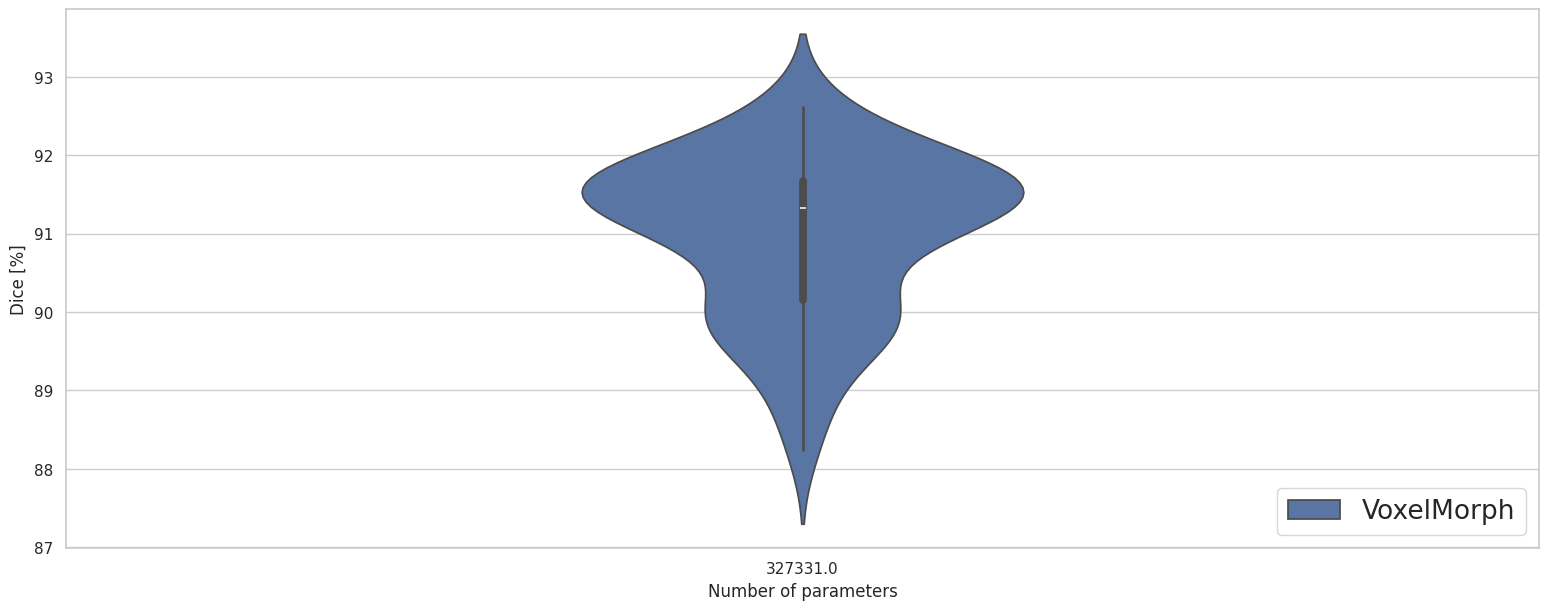

In [32]:
# Plot
from matplotlib.patches import Rectangle
kwargs = {'edgecolors':'black', 'linewidth':1}#, 'linestyle':'--'}
plt.figure(figsize=(19, 7))
sns.set_theme(style="whitegrid")
tips = sns.load_dataset("tips")


# ax=sns.scatterplot(data=data_res_inference, x="Number of parameters", y="Dice [%]", hue="Method", s=800, **kwargs) #<palette=[adjust_lightness('#fae5d6', 0.75), adjust_lightness('#deebf7', 0.75)]

ax=sns.violinplot(x="Number of parameters", y="Dice [%]", data=data_detailed_inf, hue='Method', width=0.3, dodge=False)

# ax.axhline(74, alpha=0.75, color='gray', linestyle="--")
# ax.axvline(125000, alpha=0.75, color='gray', linestyle="--")


# ax.add_patch(Rectangle((-10000, 0), 135000, 74, facecolor='c', alpha=0.17))
# ax.add_patch(Rectangle((125000, 0), 225000, 74, facecolor='r', alpha=0.17))
# ax.add_patch(Rectangle((-10000, 74), 135000, 74, facecolor='g', alpha=0.17))
# ax.add_patch(Rectangle((125000, 74), 225000, 74, facecolor='y', alpha=0.17))

lgnd = plt.legend(loc='lower right', title='', fontsize='19')
# plt.setp(ax.get_legend().get_texts(), fontsize='19') # for legend text
lgnd.legendHandles[0]._sizes = [160]
lgnd.legendHandles[1]._sizes = [160]
lgnd.legendHandles[2]._sizes = [160]
lgnd.legendHandles[3]._sizes = [160]
lgnd.legendHandles[4]._sizes = [160]
lgnd.legendHandles[5]._sizes = [160]


ax.yaxis.set_ticks([65, 70, 75, 80, 85])
# ax.xaxis.set_ticks([50000, 100000, 150000, 200000, 250000, 300000])
# ax.xaxis.set_ticklabels(["50k", "100k", "150k", "200k", "250k", "300k"])
ax.xaxis.set_ticklabels(["11k", "36k", "92k", "191k", "327k"])
ax.tick_params(axis='both', labelsize=19)
ax.set_ylabel("Dice [%]",fontsize=23)
ax.set_xlabel("Number of parameters",fontsize=23)
plt.savefig('/media/aranem_locale/AR_subs_exps/CVPR_2024/CVPR_2024_evaluation/plots_cvpr/violin_computation_v_performance.pdf', bbox_inches='tight')

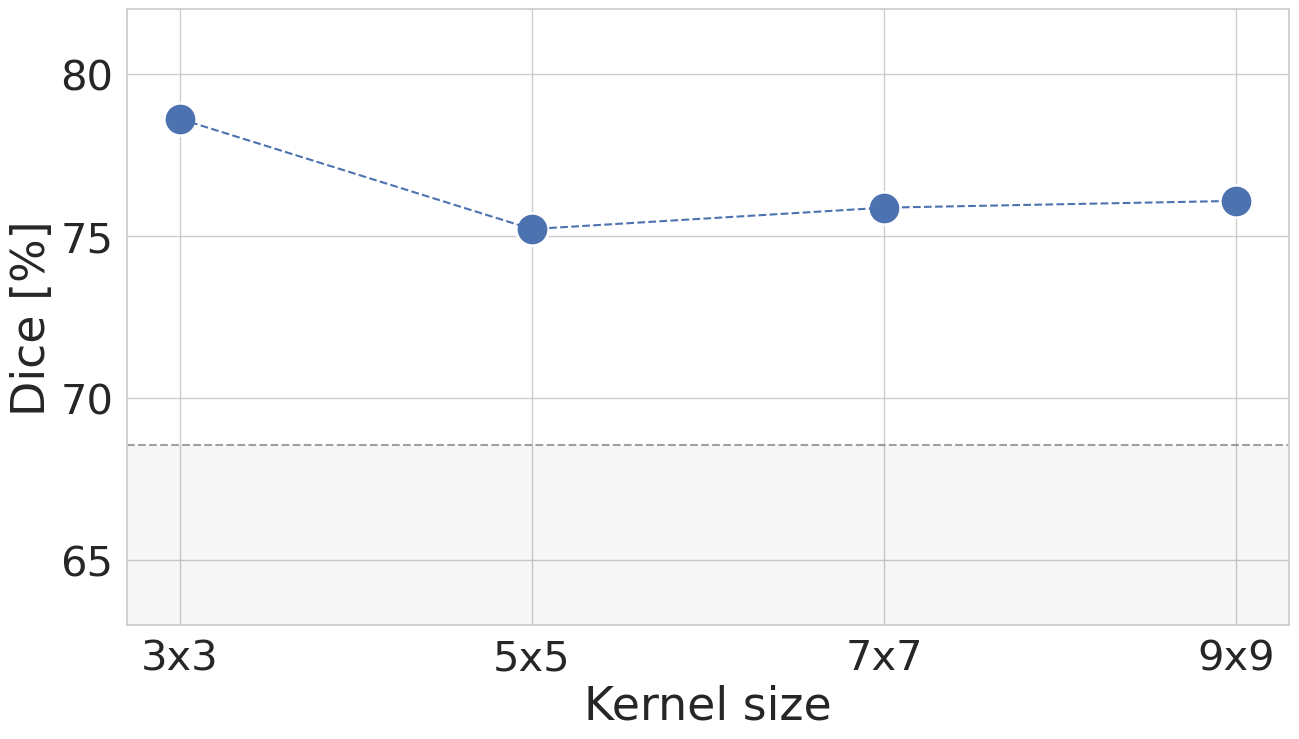

In [17]:
from matplotlib.patches import Rectangle
plt.figure(figsize=(15, 8))

kernel_size = ["3x3", "5x5", "7x7", "9x9"]
dice = [78.62, 75.22, 75.88, 76.09]
deviation = [1.58, 1.45, 1.59, 1.55]

sns.set_theme(style="whitegrid")

df = pd.DataFrame(list(zip(kernel_size, dice, deviation)), columns= ['Kernel Size', 'Dice', 'Deviation'])

ax = sns.lineplot(data=df, x="Kernel Size", y="Dice", linestyle="--") #, errorbar="Deviation")
ax = sns.scatterplot(data=df, x="Kernel Size", y="Dice", s=540) #, errorbar="Deviation")
ax.set(ylim=(63, 82))
ax.yaxis.set_ticks([65, 70, 75, 80])

ax.axhline(68.56, alpha=0.75, color='gray', linestyle="--")
ax.add_patch(Rectangle((-10, 0), 100, 68.56, facecolor='black', alpha=0.03))
ax.tick_params(axis='both', labelsize=30)
ax.set_ylabel("Dice [%]",fontsize=33)
ax.set_xlabel("Kernel size",fontsize=33)

plt.savefig('/media/aranem_locale/AR_subs_exps/CVPR_2024/CVPR_2024_evaluation/plots_cvpr/kernel_size.pdf', bbox_inches='tight')

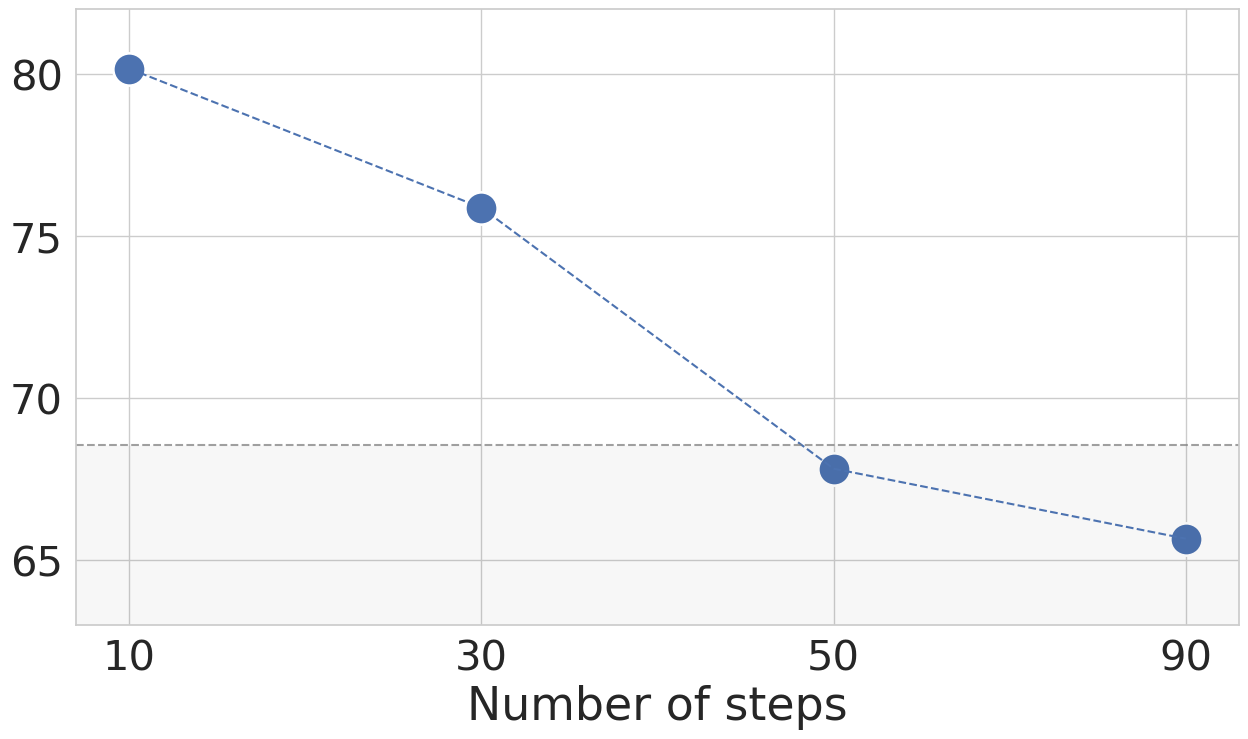

In [18]:
from matplotlib.patches import Rectangle
plt.figure(figsize=(15, 8))

steps = ["10", "30", "50", "90"]
dice = [80.17, 75.88, 67.83, 65.67]
deviation = [1.59, 1.59, 1.78, 1.9]

sns.set_theme(style="whitegrid")

df = pd.DataFrame(list(zip(steps, dice, deviation)), columns= ['Steps', 'Dice', 'Deviation'])

ax = sns.lineplot(data=df, x="Steps", y="Dice", linestyle="--") #, errorbar="Deviation")
ax = sns.scatterplot(data=df, x="Steps", y="Dice", s=540) #, errorbar="Deviation")
ax.set(ylim=(63, 82))
ax.yaxis.set_ticks([65, 70, 75, 80])

ax.axhline(68.56, alpha=0.75, color='gray', linestyle="--")
ax.add_patch(Rectangle((-10, 0), 100, 68.56, facecolor='black', alpha=0.03))
ax.tick_params(axis='both', labelsize=30)
ax.set_ylabel("",fontsize=33)
ax.set_xlabel("Number of steps",fontsize=33)
# ax.set_xticklabels(steps)
plt.savefig('/media/aranem_locale/AR_subs_exps/CVPR_2024/CVPR_2024_evaluation/plots_cvpr/step_size.pdf', bbox_inches='tight')